In [ ]:
import scipy.sparse
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from sklearn.metrics import adjusted_rand_score as rand
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [3]:
work_dir = "" # Path to the directory where the repository was cloned
os.chdir(work_dir)

In [11]:
def compute_silhouette_clustering(adata, key, figures_dir=None, figure_name=None):
    # Pre-process the data for clustering
    sc.pp.log1p(adata)
    num_pca=50
    adata.layers['unscaled'] = adata.X.copy()
    sc.pp.scale(adata)
    sc.tl.pca(adata, n_comps=num_pca, svd_solver="arpack", random_state=0)

    # kmeans clustering
    kmeans = KMeans(n_clusters=9, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = list(kmeans.labels_)
    
    # Compute performances
    ari_k = rand(labels_true=adata.obs[key].values,
                 labels_pred=adata.obs['kmeans'].values)
    
    if figures_dir:
        p = sc.pl.pca(adata, color=key, return_fig=True, title = f"{figure_name} PCA")
        p.savefig(f"{figures_dir}/{figure_name}_pca.png", 
                  dpi=300,
                 bbox_inches="tight")
        plt.close(p)
        p = sc.pl.pca(adata, color='kmeans', return_fig=True, title = f"{figure_name} kmeans")
        p.savefig(f"{figures_dir}/{figure_name}_kmeans.png", 
                  dpi=300,
                 bbox_inches="tight")
        plt.close(p)   
    return ari_k

In [5]:
def read_normalize_denoised(d, data_dir,experiment_name):

    print(f"Denoiser: {d}")
    print(f"Path to denoised: {data_dir}/denoised_{d}/{experiment_name}_denoised_{d}.csv")
    if d== "saverx":
        # SAVER-X leaves some values NA, so we set them to 0
        adata = pd.read_csv(f"{data_dir}/denoised_{d}/{experiment_name}_denoised_{d}.csv", na_values='NA')
        print(f"SAVERX: number of nan: {sum(sum(np.isnan(adata.values)))} out of {adata.shape[0] * adata.shape[1]}")
        adata = adata.fillna(0)
        adata = AnnData(adata)
        adata = adata.transpose()
    else:
        adata = sc.read_csv(f"{data_dir}/denoised_{d}/{experiment_name}_denoised_{d}.csv")
        adata = adata.transpose()
        
    # ALRA and DrImpute give log-normalized data 
    if d in ["DRimpute", 'ALRA']:
        print("Normalizing data for DRIMPUTE ALRA")
        adata.X = np.expm1(adata.X)
        
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    return adata

In [ ]:
data_directory = "./pbmc/csv_mostvar/"
noise_dir = f"{data_directory}/noise_filt"

# Retrieve filenames for each dataset with noise
filenames = os.listdir(noise_dir)
experiments = [re.sub("_noise.csv", "", x) for x in filenames]

# Retrieve the denoisers list
denoisers = os.listdir(data_directory)
denoisers = [x.split("_")[1] for 
             x 
             in 
             denoisers 
             if ("denoised" in x) and ("scRecover" not in x)]

In [5]:
# Read the file with cell type information about each PBMC
annotations = pd.read_csv("pbmc/annotation_file.csv",
                          index_col=0)

In [9]:
# Set this value if you want to save pca plot of each dataset.
figures_directory = "" 
os.makedirs(figures_directory,
            exist_ok=True)

In [ ]:
"""
Instantiate the list "results" that will contain:
    - one line per setting (i.e. before denoising and each denoised version)
    - in each line we have the ARI calculated on k-means result
"""

results = []
data_dir = "pbmc/csv_mostvar/"
for f in tqdm(filenames):
    # Read dataset with noise
    adata_tmp = sc.read_csv(f"{noise_dir}/{f}")
    adata_tmp = adata_tmp.transpose()
    experiment_name = re.sub("_noise.csv$","", f)
    
    # Now associate the celltype to each cell
    assert sum(adata_tmp.obs_names == annotations.index.values) == adata_tmp.shape[0]
    adata_tmp.obs.index = [x.replace(".", "-") for x in adata_tmp.obs_names]
    adata_tmp.obs = annotations.copy()
    
    sc.pp.normalize_total(adata_tmp, target_sum=1e4)

    ari_k = compute_silhouette_clustering(adata_tmp, 
                                          key='celltype', 
                                          figures_dir = figures_directory,
                                          figure_name = f"{experiment_name}_noise")
    
    ncells = adata_tmp.shape[0]
    ngenes = adata_tmp.shape[1]  
    results.append([experiment_name, 
                    "before denoising", 
                    ncells, 
                    ngenes, 
                    ari_k])
    
    # Now read all denoised versions for the current dataset
    for d in tqdm(denoisers):
        adata_denoised = read_normalize_denoised(d=d, 
                                                 data_dir=data_dir, 
                                                 experiment_name=experiment_name)
        adata_denoised.obs.index = [x.replace(".", "-") for x in adata_denoised.obs_names]
        assert adata_tmp.shape == adata_denoised.shape
        assert sum(adata_denoised.obs_names == annotations.index.values) == adata_denoised.shape[0]
        adata_denoised.obs = annotations.copy()
        sil, ari_k, k = compute_silhouette_clustering(adata_denoised,
                                                      key='celltype',
                                                      figures_dir="pbmc/figures_kmeans/",
                                                      figure_name=f"{experiment_name}_{d}")
        results.append([experiment_name, 
                        d, 
                        ncells, 
                        ngenes,
                        ari_k])

In [6]:
df = pd.DataFrame(results, columns=["experiment", 
                                    "method", 
                                    "ncells", 
                                    "ngenes", 
                                   "ARI kmeans"])

In [7]:
experiments = [re.sub("_noise.csv$","", f) for f in filenames]

ari_k_before = {}
for e in experiments:
    tmp = df[(df["experiment"] == e) & (df["method"] == "before denoising")]
    ari_k_before[e] = list(tmp["ARI kmeans"])[0]

In [ ]:
diff_performances = df[df["method"] != "before denoising"] 

diff_ari_k = []
for i in range(diff_performances.shape[0]):
    temp = diff_performances.iloc[i,:]
    e = temp["experiment"]
    diff_ari_k.append(temp["ARI kmeans"] - ari_k_before[e])
    
diff_performances["ARI kmeans delta"] = diff_ari_k



In [34]:
#df_plot = diff_performances[~diff_performances['method'].isin(['saverx-human-Tcells', 'saverx-human-Immune'])]

#denoisers_plot = [x for x in denoisers if x not in ['saverx-human-Tcells', 'saverx-human-Immune']]

labels_den = ['ALRA',
 'bayNorm',
 'DCA',
 'DeepImpute',
 'DrImpute',
 'ENHANCE',
 'kNN-smoothing',
 'MAGIC',
 'SAVER',
 'SAVER-X',
 'scImpute',
 'scRMD',
 'VIPER']

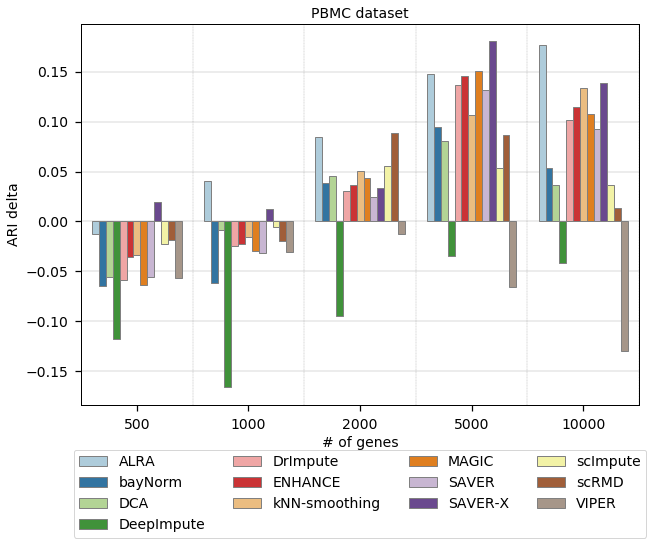

In [10]:
import matplotlib.ticker as ticker
sns.set(style='ticks',font='sans-serif')

plt.rcParams.update({'xtick.labelsize': 14,
                    'ytick.labelsize': 14,
                    'axes.labelsize': 14,
                    'axes.titlesize': 14,
                    'text.color' : 'black',
                    'axes.labelcolor': 'black',
                     'axes.edgecolor': 'black',
                     'axes.linewidth': 1,
                    'font.family': 'sans-serif',
                    'xtick.color' : 'black',
                    'ytick.color':'black'})

fig, ax1 = plt.subplots(1,1,figsize=(10, 7))
pal = sns.color_palette('Paired', 12)
pal = list(pal) + [(171/255,149/255,132/255)]

sns.barplot(data=diff_performances,
            x="ngenes", 
            y = 'ARI kmeans delta', 
            hue='method',
           palette= pal,
           ax = ax1,
           hue_order = sorted(denoisers, key=str.casefold))

# Put edge around rectangles in legend
plt.setp(ax1.patches, linewidth=1, edgecolor='0.5')

for x in np.arange(0.5, 5):
    ax1.axvline(x=x, color="grey", linestyle="--", linewidth=0.3)

plt.grid(True, axis='y', color='grey', linewidth=0.3)
L = plt.legend(loc=9, 
           ncol=4, 
           bbox_to_anchor=(0.5, -0.1), 
           fontsize=14,
          frameon=True);
# Rename labels in legend
for i,d in enumerate(labels_den):
    L.get_texts()[i].set_text(d)

ax1.set_title("PBMC dataset")
ax1.set_xlabel("# of genes")
ax1.set_ylabel("ARI delta");